# Introduction to deep learning with `keras` (and `tensorflow` backend)

For this notebook you need to install:

- `tensorflow`
- `keras`
- `keras-vis`

The easiest way is to first install the `anaconda` distribution for `python` (preferably `Python 3`) and then use in a terminal

    conda install pip
 
`pip` is the python package installation tool. Then, you can simply use

    pip install tensorflow
    pip install keras
    pip install keras-vis

which should install everything easily.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle as pkl
import os

import tensorflow
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations

#from vis.visualization import visualize_activation
#from vis.utils import utils

print("tensorflow version %s (should be at least 0.12.1)" % tensorflow.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

ImportError: cannot import name 'imresize' from 'scipy.misc' (C:\Users\jafun\Anaconda3\envs\Projet\lib\site-packages\scipy\misc\__init__.py)

# 0. Introduction: about `tensorflow` and `keras`

The `numpy` library does some expensive operations outside Python using efficient code (Fortran, C/C++). However, switching back to python after each operation cause a big overhead because of unnecessary copies of the data. 

The library `tensorflow` does all the computations outside of Python: the python API is used to define a graph of operations, that will run entirely using C++ binaries. This architecture allows to get rid of the overhead. Besides, knowing the computational graph beforehand allows to parallelize and/or distribute the computation more easily. As a result, `tensoflow` can run the computations on multiple CPUs or GPUs, and on multiple servers.

However, for quick an easy model prototying, the library `keras` is simpler to use than `tensorflow`. 
Deep learning models can be constructed thanks to `keras` in few lines of python. So in this notebook, we won't see direct calls to `tensorflow`, but only to `keras`, even if the computations are done by `tensorflow`.

# 1. Handwritten digit recognition with MNIST

For the first part of this tutorial, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level). 
These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

## 1.1. Introduction

The labels in $\{0, 1, 2, \ldots, 9\}$ giving the digit on the image are be represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

Also, MNIST data is grayscale pixels in $\{0, \ldots, 255\}$. The pixels should be normalized to belong to $[0, 1]$.
Indeed, working with big floats can lead to important numerical errors, in particular in deep learning models.
To convince yourself of the damages that can result from numerical instability, see the following cell:

In [2]:
foo = 1e9
for i in range(int(1e6)):
    foo += 1e-6
foo -= 1e9
print("Numerically instable sum: %f " % foo)

bar = 1
for i in range(int(1e6)):
    bar += 1e-6
bar -= 1
print("Numerically stable sum: %f " % bar)

Numerically instable sum: 0.953674 
Numerically stable sum: 1.000000 


## 1.2. Load the data

MNIST is a very old and standard benchmark dataset for image classification, so it's built-in (ready to be downloaded) in all machine learning libraries (including `keras` and `tensorflow`).

In [3]:
# Number of classes
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


## 1.3. A first look at the data

In the next cell we illustrate the first for elements of the training data: 
pixels grayscale of the digit and their corresponding label.

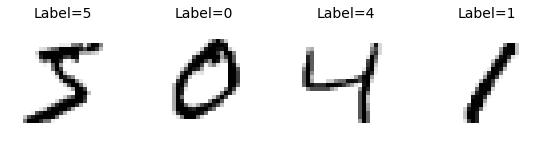

In [4]:
plt.figure(figsize=(8, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

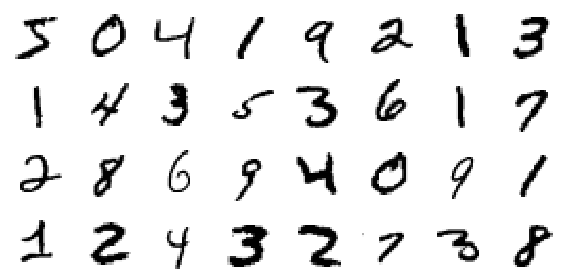

In [5]:
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

The first character is a 5 digit, encoded in grayscale matrix as follows

In [6]:
print(np.array2string(x_train[0].astype(np.int).reshape(28, 28), 
                      max_line_width=150))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   

## 1.4. Normalization and preprocessing of the data

We need to normalize the images and one-hot encode the labels.

**Warning:** call this cell only once (otherwise you'll devide several times by 255), which might be problematic later on.

In [7]:
x_train /= 255
x_test /= 255
print(x_train.min(axis=None), x_train.max(axis=None))

0.0 1.0


In [8]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

<a id='softmax'></a>
# 2. Softmax regression for MNIST

## 2.1. Description of the model

We want to classify these pictures to predict the digit $k$ they represent for $k \in \{0, \ldots, 9\}$.
A simple model allowing to do that is softmax regression.

The idea behind this model is to produce a score for each input image $x$ using a simple linear model. 
To do so, we assume that belonging to a class $k$ (corresponding to digit $k$) can be expressed by a weigthed sum of the pixel intensities, with weights $W_{k, 1}, \ldots, W_{k, 784}$ and to a bias $b_k$ capturing variability independent of the input:
$$
\text{score}_k(x_i) = \sum_{j=1}^{784} W_{k, j} x_j + b_k,
$$
These scores are sometimes called the "logits" in the deep learning community.
We then use the softmax function to convert the scores into predicted probabilities $p_k$:
$$
p_k(x_i) = \text{softmax}(\text{score}_k(x_i)) = \frac{\exp(\text{score}_k(x_i))}{\sum_{k'=1}^{10}\exp(\text{score}_{k'}(x_i))}
$$
for $k=1, \ldots, 10$.

## 2.2. The computational graph for training of softmax regression

To train the model weights $W_{k, j}$ and $b_k$ for $k=1, \ldots, 10$ and $j=1, \ldots, 784$, we consider the goodness-of-fit given by the negative log-likelihood.
For the considered model, the negative log-likelihood of a sample with input $x_i \in \mathbb R^{784}$ and label $y_i \in \{0, 1\}^{10}$, it is given by the cross-entropy between the scores $p_k(x_i)$ and the label $y_i$:
$$
- \sum_{k=1}^{10} y_{i, k} \log(p_k(x_i))
$$
For this first model, we will simply use stochastic gradient descent over small batches of data. It can be done easily with TensorFlow, as it will automatically and efficiently compute the gradient from your graph, then apply an optimization algorithm of your choice to perform the parameters update.

In [9]:
# We use a sequential model: we stack layers
model = Sequential()
# First we need to flatten the data: replace 28 * 28 matrices by flat vectors
# This is always necessary before feeding data to a fully-connected layer (Dense object)
model.add(Flatten(input_shape=input_shape, name='flatten'))
# We add one dense (fully connected layer) with softmax activation function
# Since it's the first layer, we need to give the size of input data
model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))

# We "compile" this model, 
model.compile(
    # specifying the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # We choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # We will monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## 2.3. Run the training of the model

In [10]:
batch_size = 64
epochs = 10

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 1.9717 - accuracy: 0.4017 - val_loss: 1.3725 - val_accuracy: 0.7173
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 1.3070 - accuracy: 0.7319 - val_loss: 1.0988 - val_accuracy: 0.7769
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 1.0779 - accuracy: 0.7773 - val_loss: 0.9567 - val_accuracy: 0.8033
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.9534 - accuracy: 0.7992 - val_loss: 0.8667 - val_accuracy: 0.8209
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.8697 - accuracy: 0.8140 - val_loss: 0.8035 - val_accuracy: 0.8298
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.8167 - accuracy: 0.8213 - val_loss: 0.7560 - val_accuracy: 0.8368
Epoch 7/10
938/938 [==============================] - 1s 2ms/step - loss: 0.7662 - accuracy: 0.8303 - val_loss: 0.7187 - val_accuracy: 0.8438
Epoch 

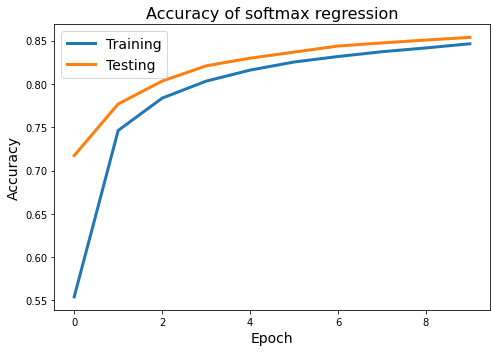

In [12]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

**QUESTION**

- Run 70 epochs and look at the training and testing accuracy curves

In [13]:
epochs = 70

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/70
938/938 [==============================] - 2s 2ms/step - loss: 0.6557 - accuracy: 0.8493 - val_loss: 0.6236 - val_accuracy: 0.8581
Epoch 2/70
938/938 [==============================] - 2s 2ms/step - loss: 0.6384 - accuracy: 0.8520 - val_loss: 0.6075 - val_accuracy: 0.8604
Epoch 3/70
938/938 [==============================] - 1s 2ms/step - loss: 0.6233 - accuracy: 0.8545 - val_loss: 0.5933 - val_accuracy: 0.8625
Epoch 4/70
938/938 [==============================] - 1s 1ms/step - loss: 0.6098 - accuracy: 0.8565 - val_loss: 0.5806 - val_accuracy: 0.8652
Epoch 5/70
938/938 [==============================] - 1s 1ms/step - loss: 0.5977 - accuracy: 0.8590 - val_loss: 0.5692 - val_accuracy: 0.8668
Epoch 6/70
938/938 [==============================] - 2s 2ms/step - loss: 0.5868 - accuracy: 0.8607 - val_loss: 0.5590 - val_accuracy: 0.8702
Epoch 7/70
938/938 [==============================] - 2s 2ms/step - loss: 0.5769 - accuracy: 0.8626 - val_loss: 0.5496 - val_accuracy: 0.8719
Epoch 

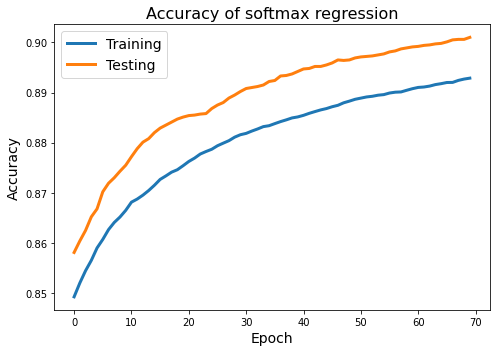

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

## 2.4. Visualisation of the model weights

Weight matrices plots show that the learned weights are consistant with the digits they should predict (see below).
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.

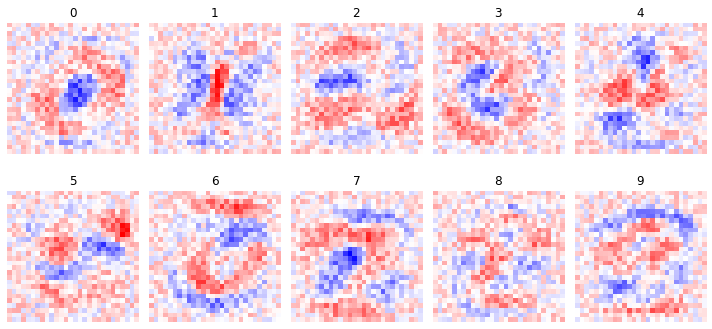

In [15]:
weights, biases = model.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

## 2.5. Saving the model

In the next cell we save the model in a file, so that it can be used later on.
This is particularly helpful when the training of models is long: we can save it every once in a while, and 
eventually continue to train it later on.

**Warning:** You need to create a `"models"` folder in the folder containing this notebook

In [16]:
path = 'models/'
model.save(os.path.join(path, 'mnist_softmax.h5'))
with open(os.path.join(path, 'mnist_softmax_history.pkl'), 'wb') as f:
    pkl.dump(history.history, f)

## 2.6. Conclusion with MNIST

You should have reached an accuracy better than 0.9 with this simple model. 
**Too easy !** You almost solved the problem using a simple softmax regression. 
Weight matrices plots show that the learned weights are consistant with the digits they should predict (see below).
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.

# 3. Towards 0.99 accuracy on MNIST

Now, let's build a better model for MNIST using more layers. 
Let's start with a feed-forward neural net (FFNN) with one hidden layer and relu activation.

## 3.1. Feed-Forward Neural Network (FFNN)

The softmax regression you just trained is a linear model, with 7850 parameters. 
It is easy to fit, numerically stable, but might be too simple for some tasks. 
The idea behind neural networks is to have a nonlinear model, while keeping the nice features of linear ones. 
The idea is to keep parameters into linear functions, and link these small linear model using non linear operations.

A simple nonlinearity which is often used to do this is the rectified linear unit
$\text{ReLU}(x) = \max(0, x)$

The derivative of this function is very easy to compute, and it is parameter-free. If we stack models such as softmax regression and ReLUs, it is still very easy to compute the gradient using the chain rule, as the model is a combination of simple functions.

The backpropagation algorithm allows efficient computation of complex derivatives as long as the function is made of simple blocks with simple derivatives. 
This algorithm efficiency is based on data reuse: when working with parallel architectures such as GPUs, you want to minimize communication (data transfer) as it is very time consuming in comparison to the computing time.

**QUESTION**

- Create the graph for a fully connected feed-forward neural network with one hidden layer with 128 units and a relu activation function. Use what you did for softmax regression (you need to add a **single line** to the code creating the softmax regression)

In [18]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))

## TODO : add a line here that adds the extra layer

model_ffnn.add(Dense(num_classes, activation='softmax'))
model_ffnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)

model_ffnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [19]:
batch_size = 32
epochs = 10

# Run the train
history = model_ffnn.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.7757 - accuracy: 0.5168 - val_loss: 1.1437 - val_accuracy: 0.7690
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0885 - accuracy: 0.7805 - val_loss: 0.9129 - val_accuracy: 0.8200
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.9071 - accuracy: 0.8142 - val_loss: 0.7998 - val_accuracy: 0.8374
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.8019 - accuracy: 0.8309 - val_loss: 0.7299 - val_accuracy: 0.8485
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7375 - accuracy: 0.8392 - val_loss: 0.6812 - val_accuracy: 0.8553
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6903 - accuracy: 0.8485 - val_loss: 0.6451 - val_accuracy: 0.8613
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6605 - accuracy: 0.8514 - val_loss: 0.6168 - val_accuracy:

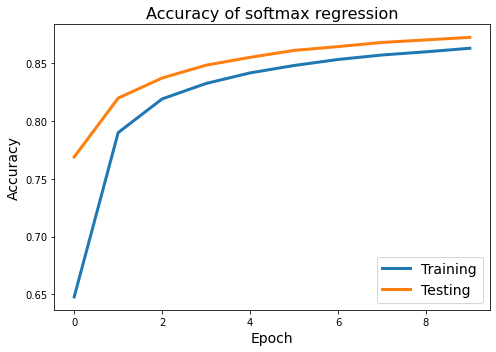

In [20]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

## 3.2. Saving the model

In [21]:
path = 'models/'
model_ffnn.save(os.path.join(path, 'mnist_ffnn.h5'))
with open(os.path.join(path, 'mnist_ffnn_history.pkl'), 'wb') as f:
    pkl.dump(history.history, f)

## 3.3. Visualize the layer

Using the function defined below, we can visualize the units of the layers.
It uses the `visualize_activation` function from the `keras-vis` library that we imported at the beginning of this notebook.
It is based on the activation maximization principle: it finds the input that maximizes the output activation of a layer, see the documentation of the `keras-vis` library for more details.

In [22]:
def visualize_layer(model, layer_name):
    layer_idx = utils.find_layer_idx(model, layer_name)
    model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(model)
    imgs = [visualize_activation(model, layer_idx, filter_indices=k,
                                 input_range=(0., 1.), tv_weight=10,
                                 lp_norm_weight=0) for k in range(10)]
    vmin = min(img.min(axis=None) for img in imgs)
    vmax = max(img.max(axis=None) for img in imgs)
    plt.figure(figsize=(10, 8))
    for k in range(10):
        img = imgs[k]
        ax = plt.subplot(3, 4, k + 1)
        ax.imshow(img.reshape(28, 28), cmap='bwr', vmin=vmin, vmax=vmax)
        plt.title('Percep. of %d' % k, fontsize=16)
        plt.axis('off')
    plt.tight_layout()

In [23]:
model_ffnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [35]:
visualize_layer(model_ffnn, 'dense_1')

NameError: name 'visualize_activation' is not defined

In [36]:
visualize_layer(model_ffnn, 'dense_2')

ValueError: No layer with name 'dense_2' within the model

**QUESTION**

- Run 60 epochs and look at the training and testing accuracy curves. Use again the visualize_layer function. Can you interpret the displays ?

<a id='cnn'></a>
## 3.2. Convolutional Neural Network

In practice, increasing the size of hidden layers is not very effective. 
It is often a better idea to add more layers. 
Intuitively, if the phenomenon you try to learn has a hierarchical structure, adding more layers can be interpreted as a way to learn more levels of abstraction. 
For example, if you are trying to recognize objects, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels. 
Thus, a good design should try to exploit this hierarchy.

In particular cases, such as grid-like data (time series, images), you might want to detect a pattern which can happen in different locations of the data. 
For example, you try to detect a cat, but the cat can be in the middle or the left of the picture. 
Thus you need to build a model which is translation invariant: it is easier to learn how to recognize an object independently of its location. 

### Description

When two inputs might contain the same kind of information, then it is useful to share their weights and train the weights jointly for those inputs to learn statistical invariants (things that don't change much on average across time or space). 
Using this concept on images leads to convolutional neural networks (CNNs), on text, it results on recurrent neural networks (RNNs). 
When using CNNs, you set weights to a small kernel that will be used to perform a convolution across the image.

The image is represented as a 3-dimensional tensor: (width, height, depth). Width and height charecterize the size of the image (eg. 28 x 28 pixels), and depth the color space (e.g. 1 for grey levels, 3 for RGB pictures since each pixel is represented by a triplet $(R,G,B)$).

<img src="./pictures/image_tensor.png",width=150,height=150>

The convolution will map patches of this image, combined with the convolution kernel, for example

$$
\text{output} = \text{ReLU}(\text{patch} \times W + b)
$$

<table>
    <tr>
        <td><img src="./pictures/convolution_kernel.png", width=200, height=200 alt="Drawing"></td>
        <td><img src="./pictures/ConvLayer.png", width=400, height=400></td>
    </tr>
</table>

Depending on the shape of the $W$ weights tensor, the tensor resulting from the convolution can have a different depth. Note that in the context of a CNN, the "kernel" can be also called a "filter".

Performing the convolution between the image and the kernel consist to move the kernel across the image, and to produce an output for each patch. 
The way you move across the image is defined by two parameters:

- **Stride:** the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- **Padding:** defines what happens when the kernel reaches a border of the image when doing the convolution. 
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

For example, a convolution with a stride $> 1$ and valid padding results in a tensor of smaller width and height. 
You can compute the size of a tensor after convolution using the following formulas:

#### Valid padding
$$
\text{out}_{\text{height}} = \bigg\lceil \frac{\text{in}_{\text{height}} - \text{kernel}_{\text{height}} + 1}{\text{stride}_{\text{vertical}}} \bigg\rceil \quad \text{ and } \quad
\text{out}_{\text{width}} = \bigg\lceil \frac{\text{in}_{\text{width}} - \text{kernel}_{\text{width}} + 1}{\text{stride}_{\text{horizontal}}} \bigg\rceil
$$

#### Same padding
$$
\text{out}_{\text{height}} = \bigg\lceil \frac{\text{in}_{\text{height}}}{\text{strides}_{\text{vertical}}} 
\bigg\rceil \quad \text{ and } \quad 
\text{out}_{\text{width}} = \bigg\lceil \frac{\text{in}_{\text{width}}}{\text{strides}_{\text{horizontal}}} \bigg\rceil
$$

**Example.**
Assume the input tensor is 28x28x3 and the convolution kernel takes in 4x4x3 tensors and outputs 1x1x32 tensors (height x width x depth), i.e the kernel takes in a patch of size 4x4 and depth 3, and output a patch of size 1x1 and depth 32. To do so, the weights tensor $W$ should be 3x3x3x32 (in-height, in-width, in-depth, out-depth). 
If we are using a stride of 1, the output tensor will be 28x28x32 with same padding, and 25x25x32 with valid padding.
Using a stride of 2, the output tensor will be 14x14x32 with same padding, and 13x13x32 with valid padding.

Striding is an agressive method to reduce the image size. 
Instead, it can be a better idea to use a stride of 1 and to combine the convolution's outputs being in some neighborhood. Such an operation combining elements of a tensor is called **pooling**. 
Neighborhoods are define by the pooling window dimension (width x height) and the strides you use when moving this window across the image.

**Example.**
Max pooling aggregate several outputs in a neighborhood $N$ using a max operation: 

$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding.

Many successful architectures stack convolution layers in a "pyramidal" way: each convolution layer result in a tensor with increased depth and decreased height and width. 
Roughly, increasing the depth increases the complexity of the semantic compexity of your representation, and allows to keep the relevant information in a smaller space (height x width). 

**QUESTION**

Implement a CNN having the following structure:

1. Convolutional layer with 32 filters and 3 * 3 kernel sizes and 'relu' activation (use the `Conv2D` object)
- Convolutional layer with 64 filters and 3 * 3 kernel sizes and 'relu' activation (use the `Conv2D` object)
- Max pooling with pool size 2 * 2 (use the `MaxPooling2D` object)
- Dropout with probability 0.25 (use the `Dropout` object)
- Dense layer with 128 units with relu activation
- Dropout with probability 0.5
- Dense output layer with softmax activation

In [72]:
model_cnn = Sequential()

# TODO Add the required layers in model_cnn here
model_cnn.add(Conv2D(32, (3, 3), input_shape=input_shape,activation='relu'))
model_cnn.add(Conv2D(64, (3, 3),activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add (Dense (128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes,activation ='softmax'))
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)             

In [73]:
batch_size = 32
epochs = 5

# Run the train
history = model_cnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
score = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1875/1875 [==============================] - 80s 42ms/step - loss: 2.2780 - accuracy: 0.1550 - val_loss: 2.1362 - val_accuracy: 0.5313
Epoch 2/5
1875/1875 [==============================] - 84s 45ms/step - loss: 2.0996 - accuracy: 0.3940 - val_loss: 1.8493 - val_accuracy: 0.6822
Epoch 3/5
1875/1875 [==============================] - 85s 45ms/step - loss: 1.8136 - accuracy: 0.5263 - val_loss: 1.4430 - val_accuracy: 0.7663
Epoch 4/5
1875/1875 [==============================] - 88s 47ms/step - loss: 1.4649 - accuracy: 0.6115 - val_loss: 1.0708 - val_accuracy: 0.8039
Epoch 5/5
1875/1875 [==============================] - 86s 46ms/step - loss: 1.1757 - accuracy: 0.6659 - val_loss: 0.8299 - val_accuracy: 0.8250
Test loss: 0.8298760056495667
Test accuracy: 0.824999988079071


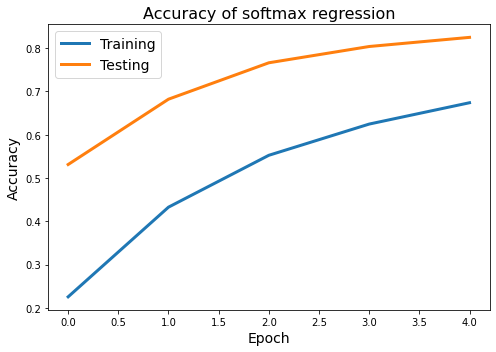

In [74]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

## 3.3. Save the model and its history

Save the model and its history using the following cell (so that you can continue to train it later...)

In [75]:
path = 'models/'
model_cnn.save(os.path.join(path, 'mnist_cnn.h5'))
with open(os.path.join(path, 'mnist_cnn_history.pkl'), 'wb') as f:
    pkl.dump(history.history, f)

**QUESTION**

Try to find a way to visualize and interpret the layers of this CNN (this question can be skipped at first).

# 4. MNIST is too easy: let's classify weird letters now (notMNIST)

MNIST is a very very **clean** dataset. Digits are rescaled, smoothed, centered, and pixel values are normalized beforehand. Let's switch to a slightly harder dataset: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

This time, labels are letters from 'A' to 'J' (10 classes). 
These letters are taken from digital fonts instead of handwriting pictures. 
We will use a reduced amount of data to ensure a reasonable training time. 
The training set you will use has 200K labelled examples, while the validation and test sets both contain 10K labelled examples.

**Notes**
- The notMNIST data that we'll load is already normalized in [-0.5, 0.5] with one-hot encoded labels

## 4.1. Load the notMNIST dataset

In [117]:
pickle_file = "./notMNIST.pickle"

with open(pickle_file, 'rb') as f:
    data = pkl.load(f)

In [118]:
data.keys()

dict_keys(['valid_labels', 'valid_dataset', 'train_labels', 'test_labels', 'test_dataset', 'train_dataset'])

In [119]:
def reshape(x, image_data_format, img_rows, img_cols):
    if image_data_format == 'channels_first':
        return x.astype(np.float32).reshape((-1, 1, img_rows, img_cols))
    else:
        return x.astype(np.float32).reshape((-1, img_rows, img_cols, 1))

img_rows, img_cols = 28, 28
num_labels = 10
image_data_format = K.image_data_format()

if image_data_format == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
    
x_train = reshape(data['train_dataset'], image_data_format, img_rows, img_cols)
x_valid = reshape(data['valid_dataset'], image_data_format, img_rows, img_cols)
x_test = reshape(data['test_dataset'], image_data_format, img_rows, img_cols)

y_train = keras.utils.to_categorical(data['train_labels'])
y_valid = keras.utils.to_categorical(data['valid_labels'])
y_test = keras.utils.to_categorical(data['test_labels'])

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'training samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'testing samples')

x_train shape: (200000, 28, 28, 1)
x_valid shape: (10000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (200000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)
200000 training samples
10000 validation samples
10000 testing samples


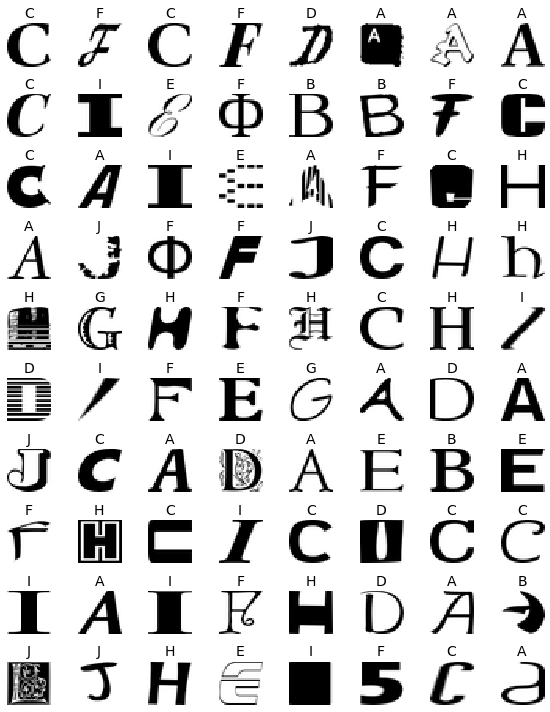

In [120]:
# plt.figure(figsize=(8, 4))
n_rows = 10
n_cols = 8
plt.figure(figsize=(n_cols, n_rows))

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def get_label(y):
    return letters[y.argmax()]

for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(y_train[i]), fontsize=14)
    ax.axis("off")
plt.tight_layout()

## 4.2 Training a softmax model on notMNIST

**QUESTION**

- Train a softmax regression, visualize the weights, plot the convergence curves, save the model and its history (start with a small number of epochs, and increase the number of epochs later).

In [121]:
model = Sequential()
# First we need to flatten the data: replace 28 * 28 matrices by flat vectors
# This is always necessary before feeding data to a fully-connected layer (Dense object)
model.add(Flatten(input_shape=input_shape, name='flatten'))
# We add one dense (fully connected layer) with softmax activation function
# Since it's the first layer, we need to give the size of input data
model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))

# We "compile" this model, 
model.compile(
    # specifying the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # We choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # We will monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [122]:
batch_size = 64
epochs = 10

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 1.3170 - accuracy: 0.6397 - val_loss: 0.6561 - val_accuracy: 0.8490
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.8185 - accuracy: 0.7930 - val_loss: 0.5811 - val_accuracy: 0.8615
Epoch 3/10
3125/3125 [==============================] - 3s 856us/step - loss: 0.7696 - accuracy: 0.8011 - val_loss: 0.5497 - val_accuracy: 0.8666
Epoch 4/10
3125/3125 [==============================] - 3s 837us/step - loss: 0.7450 - accuracy: 0.8066 - val_loss: 0.5315 - val_accuracy: 0.8710
Epoch 5/10
3125/3125 [==============================] - 3s 839us/step - loss: 0.7267 - accuracy: 0.8109 - val_loss: 0.5196 - val_accuracy: 0.8734
Epoch 6/10
3125/3125 [==============================] - 3s 905us/step - loss: 0.7199 - accuracy: 0.8118 - val_loss: 0.5105 - val_accuracy: 0.8750
Epoch 7/10
3125/3125 [==============================] - 3s 833us/step - loss: 0.7117 - accuracy: 0.8134 - val_loss: 0.5037 - val

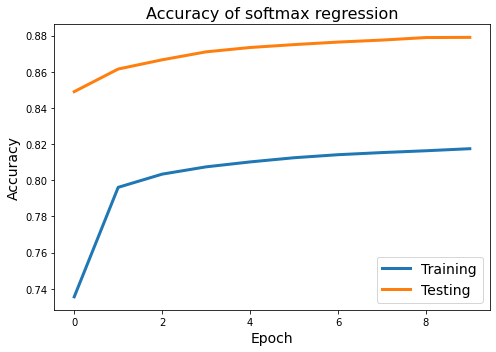

In [123]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

In [124]:
batch_size = 64
epochs = 30

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
3125/3125 [==============================] - 3s 875us/step - loss: 0.6958 - accuracy: 0.8181 - val_loss: 0.4867 - val_accuracy: 0.8796
Epoch 2/30
3125/3125 [==============================] - 3s 831us/step - loss: 0.6931 - accuracy: 0.8188 - val_loss: 0.4839 - val_accuracy: 0.8802
Epoch 3/30
3125/3125 [==============================] - 3s 820us/step - loss: 0.6907 - accuracy: 0.8195 - val_loss: 0.4814 - val_accuracy: 0.8810
Epoch 4/30
3125/3125 [==============================] - 3s 860us/step - loss: 0.6885 - accuracy: 0.8199 - val_loss: 0.4791 - val_accuracy: 0.8817
Epoch 5/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.6866 - accuracy: 0.8204 - val_loss: 0.4771 - val_accuracy: 0.8822
Epoch 6/30
3125/3125 [==============================] - 3s 848us/step - loss: 0.6848 - accuracy: 0.8207 - val_loss: 0.4753 - val_accuracy: 0.8835
Epoch 7/30
3125/3125 [==============================] - 3s 840us/step - loss: 0.6832 - accuracy: 0.8210 - val_loss: 0.4737 - v

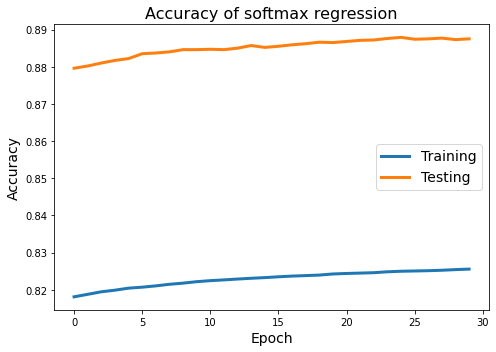

In [125]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

## 4.3. Training a one-layer FFNN on notMNIST

**QUESTION**

- Train FFNN with one hidden layer with 128 units, visualize the convergence curves, visualize the weights, save the model and its history.

## 4.4 Training a deeper CNN for notMNIST

**QUESTION**

Train a CNN with the following structure:

1. Convolutional layer with 32 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25
- Dense layer with 1024 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

Use the Adam solver. Train for 20 epochs or more (this might take a loooong) time.

You should achieve >= 97% accuracy on test set

- Save the model and visualize the last fully connected layers

In [135]:
model_cnn = Sequential()

# TODO Add the required layers in model_cnn here
model_cnn.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (5, 5),activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add (Dense (1024))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes,activation ='softmax'))
my_optimiser = tensorflow.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=my_optimiser,
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)            

In [138]:
batch_size = 64
epochs = 20

# Run the train
history = model_cnn.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
3125/3125 [==============================] - 901s 288ms/step - loss: 0.4189 - accuracy: 0.8791 - val_loss: 0.1915 - val_accuracy: 0.9451
Epoch 2/20
3125/3125 [==============================] - 896s 287ms/step - loss: 0.3794 - accuracy: 0.8896 - val_loss: 0.1733 - val_accuracy: 0.9500
Epoch 3/20
3125/3125 [==============================] - 892s 285ms/step - loss: 0.3585 - accuracy: 0.8956 - val_loss: 0.1633 - val_accuracy: 0.9543
Epoch 4/20
3125/3125 [==============================] - 902s 288ms/step - loss: 0.3441 - accuracy: 0.8994 - val_loss: 0.1564 - val_accuracy: 0.9559
Epoch 5/20
3125/3125 [==============================] - 896s 287ms/step - loss: 0.3360 - accuracy: 0.9013 - val_loss: 0.1548 - val_accuracy: 0.9536
Epoch 6/20
3125/3125 [==============================] - 901s 288ms/step - loss: 0.3270 - accuracy: 0.9037 - val_loss: 0.1484 - val_accuracy: 0.9565
Epoch 7/20
3125/3125 [==============================] - 887s 284ms/step - loss: 0.3190 - accuracy: 0.9057 - val_

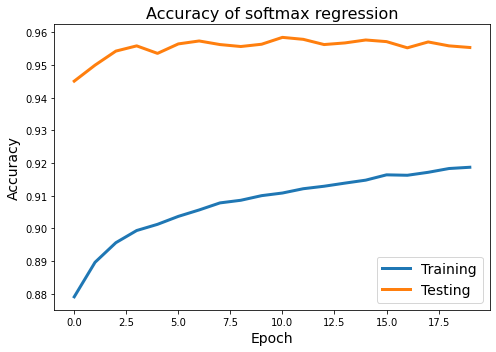

In [139]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()